**VISUALISATIONS**
-------

In this notebook, we will visualise the shape of our data

In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import os

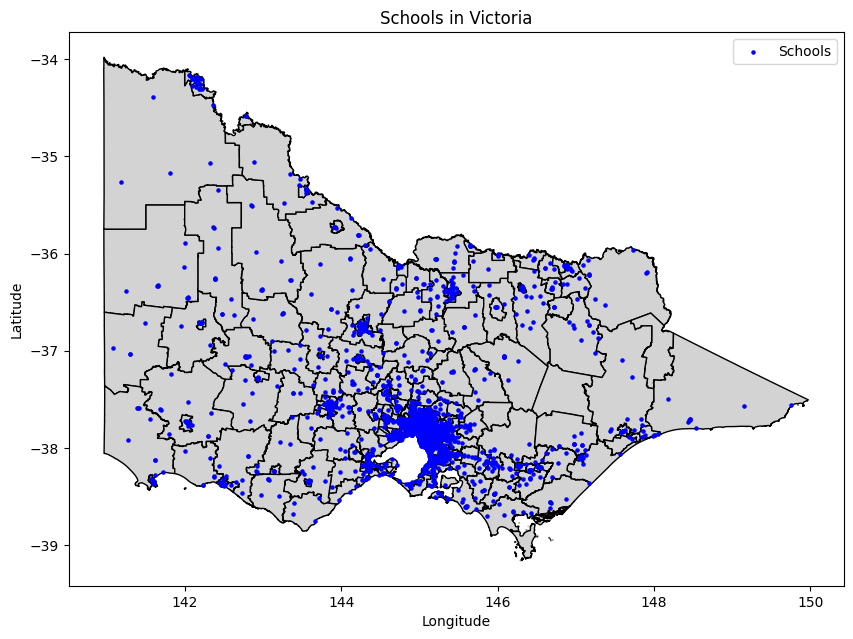

In [50]:
# Step 1: Load the Victoria boundary spatial data (SA2 shapefile)
sa2_path = '../data/raw/SA2_2021_AUST_GDA2020.shp'
gdf = gpd.read_file(sa2_path)

# Step 2: Filter to include only Victoria (State code 2)
victoria_gdf = gdf[gdf['STE_CODE21'] == '2']

# Step 3: Load the school data with the correct encoding
school_data_path = '../data/raw/dv346-schoollocations2023.csv'
school_df = pd.read_csv(school_data_path, encoding='ISO-8859-1')  # Use appropriate encoding

# Step 4: Convert the school data into a GeoDataFrame using the Y (latitude) and X (longitude) columns
school_df['geometry'] = school_df.apply(lambda row: Point(row['X'], row['Y']), axis=1)
school_gdf = gpd.GeoDataFrame(school_df, geometry='geometry', crs='EPSG:4326')  # Assuming WGS 84 CRS

# Step 5: Reproject Victoria's shapefile to match the CRS of the school data (if necessary)
victoria_gdf = victoria_gdf.to_crs(epsg=4326)

# Step 6: Plot both the Victoria boundary and school locations
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Victoria boundaries
victoria_gdf.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot schools on top
school_gdf.plot(ax=ax, color='blue', markersize=5, label='Schools')

plt.title('Schools in Victoria')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


/var/folders/gd/m0kqkz893_x6z1pmcms3kw_r0000gn/T/ipykernel_1765/1479218602.py:38: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/gd/m0kqkz893_x6z1pmcms3kw_r0000gn/T/ipykernel_1765/1479218602.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


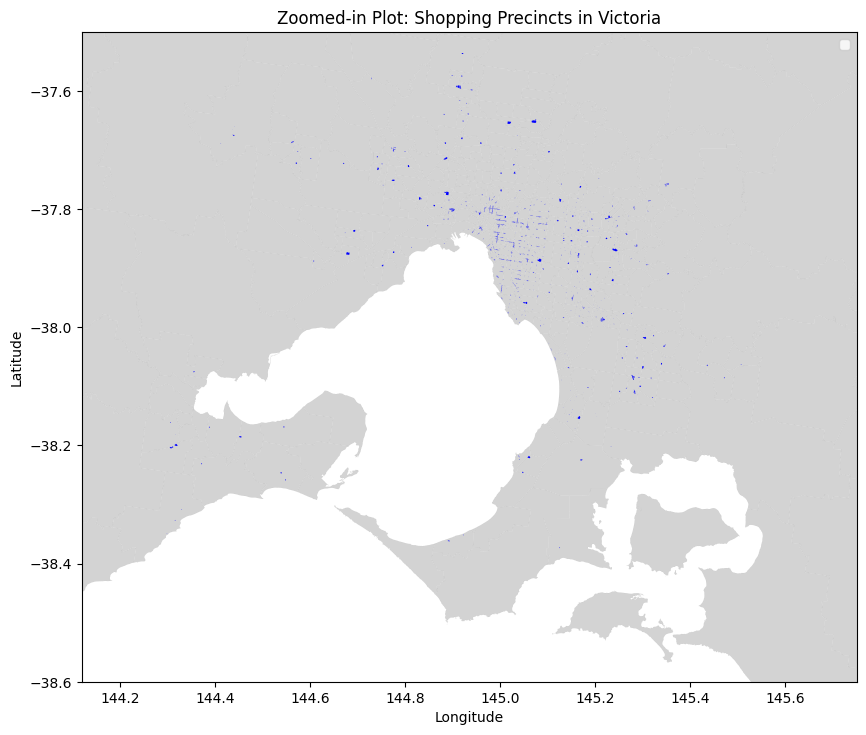

In [37]:
# Directories
data_dir = '../data/'
landing_dir = data_dir + 'landing/'
curated_dir = data_dir + 'curated/'

pd.set_option('display.max_columns', None)

shopping_parks_sf = gpd.read_file(f"{landing_dir}FOI/GEOMARK_POLYGON.shp")

shopping_type = "commercial facility"
shopping_labels = ["shopping precinct", "shopping centre"]
shopping_sf = shopping_parks_sf[shopping_parks_sf['STATE'] == "VIC"]
shopping_sf = shopping_sf[shopping_sf['FTYPE'] == shopping_type]
shopping_sf = shopping_sf[shopping_sf['FEATSUBTYP'].isin(shopping_labels)]
shopping_sf = shopping_sf.reset_index(drop=True)
shopping_sf = shopping_sf.to_crs(epsg=4326)

sa2_path = '../data/sa2_shapefile/SA2_2021_AUST_GDA2020.shp'
gdf = gpd.read_file(sa2_path)
victoria_gdf = gdf[gdf['STE_CODE21'] == '2']
victoria_gdf = victoria_gdf.to_crs(epsg=4326)

# Step 6: Plot both the Victoria boundary and school locations
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlim([144.12, 145.75]) 
ax.set_ylim([-38.6, -37.5]) 

# Plot Victoria boundaries
victoria_gdf.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.01)

# Plot schools on top
shopping_sf.plot(ax=ax, color='blue', markersize=5,  label='Shopping Precincts')

plt.title('Zoomed-in Plot: Shopping Precincts in Victoria')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

/var/folders/gd/m0kqkz893_x6z1pmcms3kw_r0000gn/T/ipykernel_1765/3510262624.py:26: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/gd/m0kqkz893_x6z1pmcms3kw_r0000gn/T/ipykernel_1765/3510262624.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


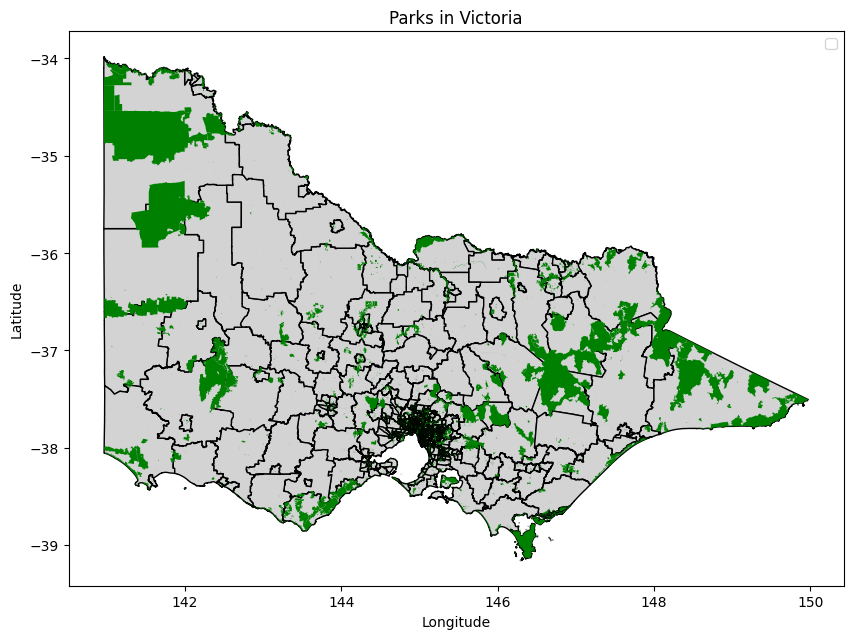

In [27]:
parks_type = "reserve"
parks_labels = ["park", "conservation park", "gardens", "national park", "city square"]
parks_sf = shopping_parks_sf[shopping_parks_sf['STATE'] == "VIC"]
parks_sf = parks_sf[parks_sf['FTYPE'] == parks_type]
parks_sf = parks_sf[parks_sf['FEATSUBTYP'].isin(parks_labels)]
parks_sf = parks_sf.reset_index(drop=True)
parks_sf = parks_sf.to_crs(epsg=4326)

sa2_path = '../data/sa2_shapefile/SA2_2021_AUST_GDA2020.shp'
gdf = gpd.read_file(sa2_path)
victoria_gdf = gdf[gdf['STE_CODE21'] == '2']
victoria_gdf = victoria_gdf.to_crs(epsg=4326)

# Step 6: Plot both the Victoria boundary and school locations
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Victoria boundaries
victoria_gdf.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot schools on top
parks_sf.plot(ax=ax, color='green', markersize=50, label='Parks')

plt.title('Parks in Victoria')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

C:\Users\AX50931\AppData\Local\Temp\ipykernel_30904\3079502585.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  schools['geometry'] = schools.apply(lambda row: Point(row['X'], row['Y']), axis=1)


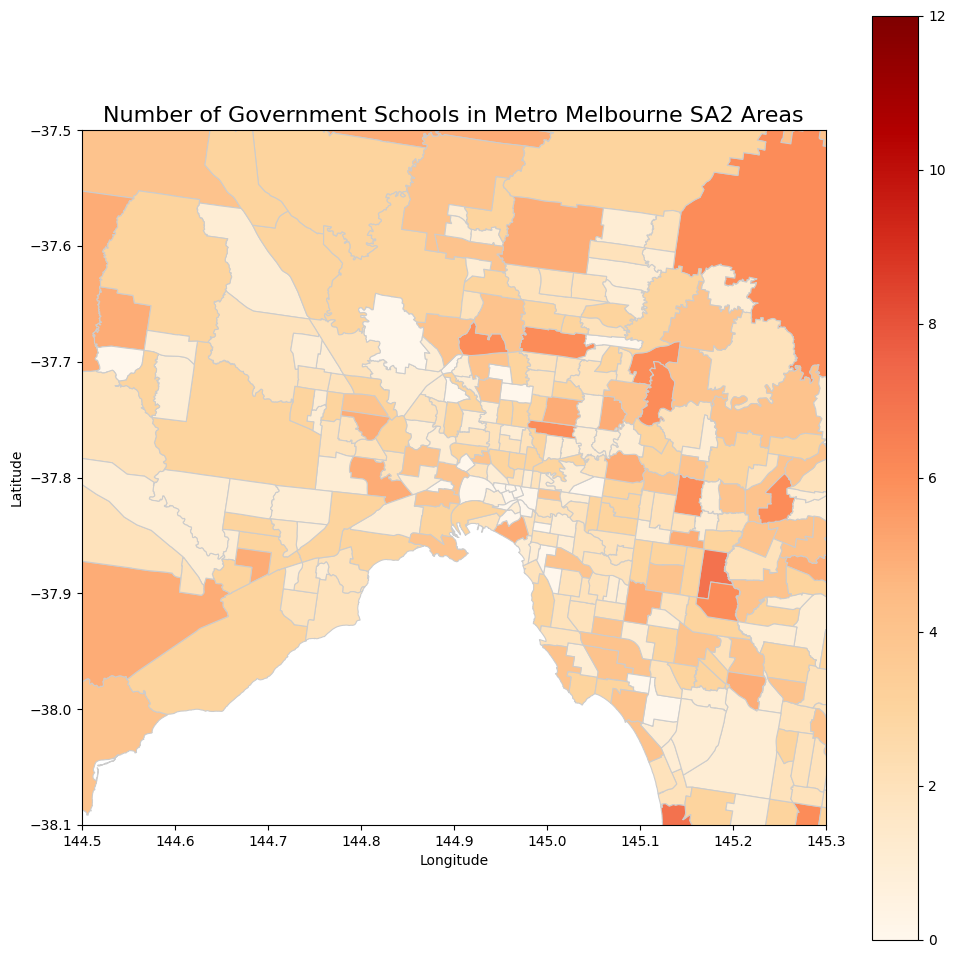

C:\Users\AX50931\AppData\Local\Temp\ipykernel_30904\3079502585.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  schools['geometry'] = schools.apply(lambda row: Point(row['X'], row['Y']), axis=1)


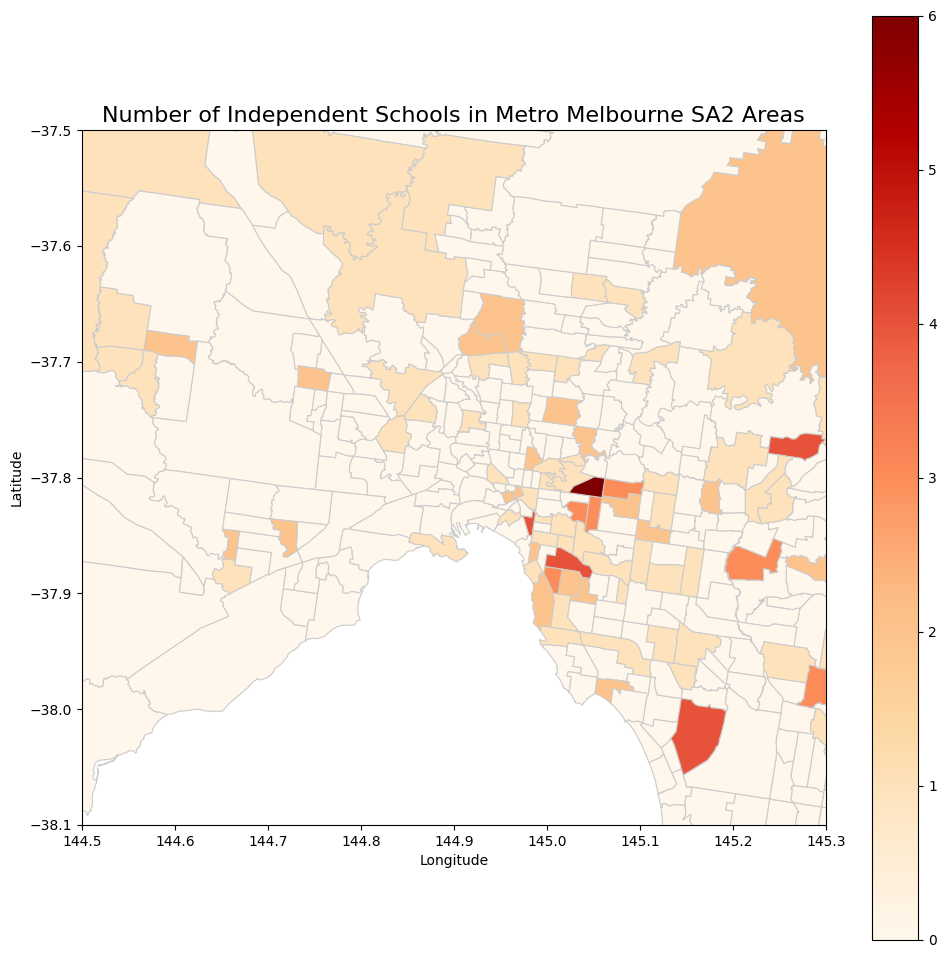

C:\Users\AX50931\AppData\Local\Temp\ipykernel_30904\3079502585.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  schools['geometry'] = schools.apply(lambda row: Point(row['X'], row['Y']), axis=1)


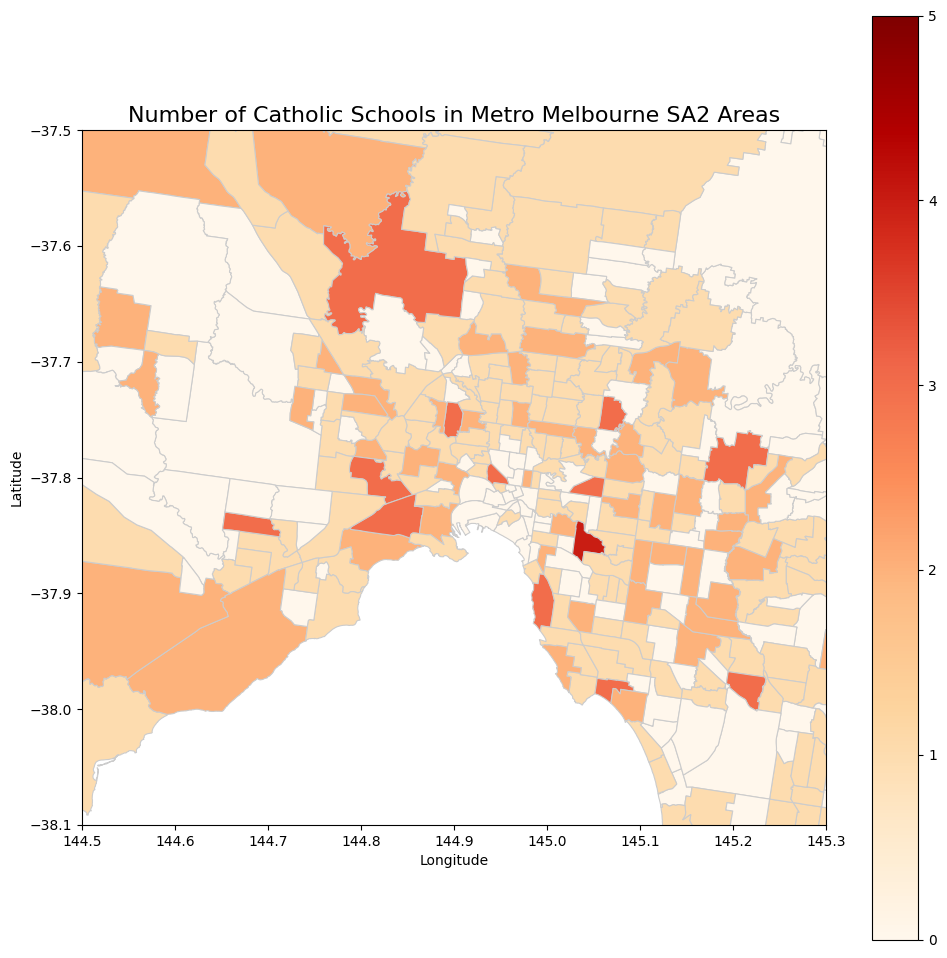

In [51]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import os

# Ensure the directory exists
output_dir = '../plots/maps/'
os.makedirs(output_dir, exist_ok=True)

# Set your bounding box for metro Melbourne (these are approximate)
minx, miny, maxx, maxy = 144.5, -38.1, 145.3, -37.5
#144.6, -38.2, 145.6, -37.4  # Approx. bounding box for Melbourne metro area
#144.5, -38.1, 145.3, -37.5
# Step 1: Define a function to plot school heatmaps based on the Education Sector and save the plot as JPEG
def plot_school_heatmap(school_df, victoria_gdf, education_sector, title, filename):
    # Filter schools by the provided education sector
    schools = school_df[school_df['Education_Sector'] == education_sector]
    
    # Convert the school data into a GeoDataFrame using the Y (latitude) and X (longitude) columns
    schools['geometry'] = schools.apply(lambda row: Point(row['X'], row['Y']), axis=1)
    schools_gdf = gpd.GeoDataFrame(schools, geometry='geometry', crs='EPSG:4326')  # Assuming WGS 84 CRS

    # Reproject the Victoria shapefile to match the CRS of the school data (if necessary)
    victoria_gdf = victoria_gdf.to_crs(epsg=4326)

    # Perform a spatial join to assign each school to its respective SA2 area (use 'predicate' instead of 'op')
    schools_in_sa2 = gpd.sjoin(schools_gdf, victoria_gdf, how='inner', predicate='within')

    # Count the number of schools in each SA2 area
    schools_per_sa2 = schools_in_sa2.groupby('SA2_NAME21').size().reset_index(name='school_count')

    # Merge the school counts with the Victoria SA2 GeoDataFrame
    victoria_gdf = victoria_gdf.merge(schools_per_sa2, on='SA2_NAME21', how='left')

    # Fill NaN values with 0 (areas with no schools)
    victoria_gdf['school_count'] = victoria_gdf['school_count'].fillna(0)

    # Plot the heatmap
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))

    # Plot SA2 regions, with the color based on the number of schools
    victoria_gdf.plot(column='school_count', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

    # Set the limits to zoom in to metro Melbourne
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    # Set plot title and labels
    plt.title(title, fontsize=16)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Save the plot as a JPEG file
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, format='jpeg', dpi=300)
    plt.show()
    plt.close()

# Step 2: Generate heatmaps for 'Government', 'Independent', and 'Catholic' schools and save them as JPEG
plot_school_heatmap(school_df, victoria_gdf, 'Government', 'Number of Government Schools in Metro Melbourne SA2 Areas', 'government_schools_metro.jpeg')
plot_school_heatmap(school_df, victoria_gdf, 'Independent', 'Number of Independent Schools in Metro Melbourne SA2 Areas', 'independent_schools_metro.jpeg')
plot_school_heatmap(school_df, victoria_gdf, 'Catholic', 'Number of Catholic Schools in Metro Melbourne SA2 Areas', 'catholic_schools_metro.jpeg')
